# **Fine-Tuning BERT model**

### Import all the necessary libraries

In [ ]:
import os
import numpy as np
import collections
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
from datasets import load_from_disk, load_dataset, load_metric
from transformers import AutoTokenizer,default_data_collator, AutoModelForQuestionAnswering, TrainingArguments, Trainer, pipeline

### Importing the legal contract dataset from huggingface

In [ ]:
# Load the CUAD dataset
dataset = load_dataset("theatticusproject/cuad-qa")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 22450
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 4182
    })
})


### Loading our RoBERTa BERT based variant model and the tokenizer

In [ ]:
model_name = "deepset/roberta-base-squad2"

# deepset/bert-large-uncased-whole-word-masking-squad2
# Rakib/roberta-base-on-cuad

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name).to("cuda")

Preprocessing the dataset to remove noise and make it ready for fine tuning the bert model

In [ ]:
def extract_relevant_question(sample):
    # Find the index of the "Details: " substring
    details_index = sample['question'].find("Details: ")

    # Extract the substring starting from the index after "Details: "
    sample['question'] = sample['question'][details_index + len("Details: "):].strip()

    return sample

# Apply the function to each sample in the dataset
dataset = dataset.map(extract_relevant_question)
dataset = dataset.filter(lambda x: len(x['answers']["text"])!= 0)
print(dataset)

Filter: 100%|██████████| 1244/1244 [00:00<00:00, 15198.75 examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11180
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1244
    })
})


In [ ]:
os.makedirs("filtered-dataset", exist_ok=True)
dataset.save_to_disk("filtered-dataset")

Saving the dataset (0/2 shards):   0%|          | 0/11180 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1244 [00:00<?, ? examples/s]

In [ ]:
# dataset = load_from_disk("./filtered-dataset")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11180
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1244
    })
})


## Analysing the context length in our dataset

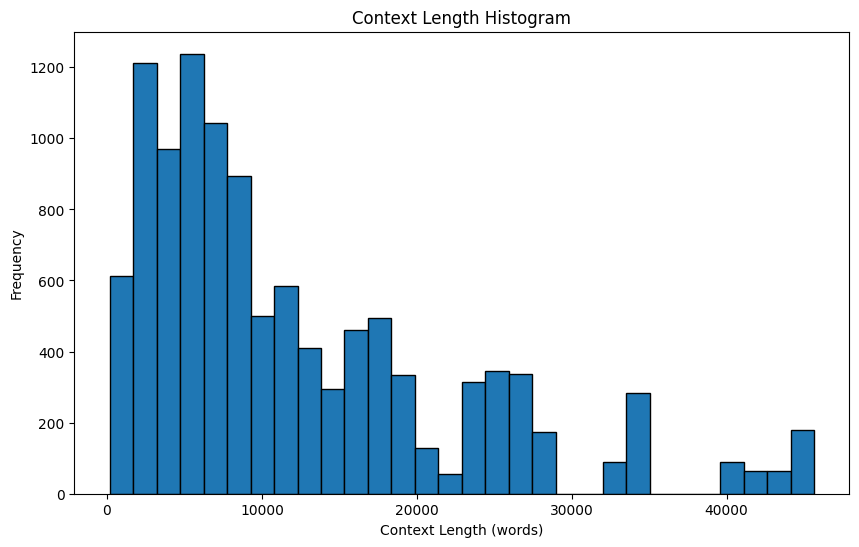

Minimum context length: 170 words
Maximum context length: 45650 words
Average context length: 12271.25 words


In [ ]:
context_lengths = [len(example['context'].split()) for example in dataset["train"]]

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(context_lengths, bins=30, edgecolor='k')
plt.title("Context Length Histogram")
plt.xlabel("Context Length (words)")
plt.ylabel("Frequency")
# plt.grid(True)


# Show the plot
plt.show()

# Print some statistics
print(f"Minimum context length: {min(context_lengths)} words")
print(f"Maximum context length: {max(context_lengths)} words")
print(f"Average context length: {sum(context_lengths) / len(context_lengths):.2f} words")

## Tokenizing our dataset so that BERT can understand it.

In [ ]:
def preprocess_train_features(examples):
    tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_overflowing_tokens=True,
        stride=128,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    offset_mapping = tokenized_examples.pop("offset_mapping")

    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):

        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        sequence_ids = tokenized_examples.sequence_ids(i)

        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]

        start_char = answers["answer_start"][0]
        end_char = start_char + len(answers["text"][0])

        token_start_index = 0
        while sequence_ids[token_start_index] != 1:
            token_start_index += 1

        token_end_index = len(input_ids) - 1
        while sequence_ids[token_end_index] != 1:
            token_end_index -= 1

        if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                token_start_index += 1
            tokenized_examples["start_positions"].append(token_start_index - 1)
            while offsets[token_end_index][1] >= end_char:
                token_end_index -= 1
            tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

# Tokenization
train_tokenized_data = dataset["train"].map(preprocess_train_features, num_proc=12, batched=True, remove_columns=dataset["train"].column_names)

In [ ]:
print(train_tokenized_data)

Dataset({
    features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 1000229
})


In [ ]:
def prepare_test_features(examples):
    tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_overflowing_tokens=True,
        stride=128,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized_examples["offset_mapping"]

    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        sequence_ids = tokenized_examples.sequence_ids(i)

        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]

        start_char = answers["answer_start"][0]
        end_char = start_char + len(answers["text"][0])

        token_start_index = 0
        while sequence_ids[token_start_index] != 1:
            token_start_index += 1

        token_end_index = len(input_ids) - 1
        while sequence_ids[token_end_index] != 1:
            token_end_index -= 1

        if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                token_start_index += 1
            tokenized_examples["start_positions"].append(token_start_index - 1)
            while offsets[token_end_index][1] >= end_char:
                token_end_index -= 1
            tokenized_examples["end_positions"].append(token_end_index + 1)


    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1

        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

test_tokenized_data = dataset['test'].map(prepare_test_features,num_proc=8, batched=True, remove_columns=dataset["test"].column_names)

Map (num_proc=8): 100%|██████████| 1244/1244 [00:16<00:00, 74.51 examples/s] 


In [ ]:
print(test_tokenized_data)

Dataset({
    features: ['input_ids', 'attention_mask', 'offset_mapping', 'start_positions', 'end_positions', 'example_id'],
    num_rows: 83005
})


# Training the BERT model on the tokenized dataset and specific training arguments

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    eval_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    weight_decay=0.01,
    save_steps=100,
    save_total_limit=2,
    dataloader_num_workers=4,
    logging_steps=1000,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized_data,
    eval_dataset=test_tokenized_data,
    tokenizer=tokenizer,
    data_collator=default_data_collator,
)

trainer.train(resume_from_checkpoint=True)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.043100,0.053207


TrainOutput(global_step=31258, training_loss=0.0043619934981215126, metrics={'train_runtime': 1888.831, 'train_samples_per_second': 529.549, 'train_steps_per_second': 16.549, 'total_flos': 1.960174452699694e+17, 'train_loss': 0.0043619934981215126, 'epoch': 1.0})

## Saving the fine-tuned models locally

In [ ]:
trainer.model.save_pretrained("finetuned-roberta")
tokenizer.save_pretrained("finetuned-roberta")

('finetuned-roberta/tokenizer_config.json',
 'finetuned-roberta/special_tokens_map.json',
 'finetuned-roberta/vocab.json',
 'finetuned-roberta/merges.txt',
 'finetuned-roberta/added_tokens.json',
 'finetuned-roberta/tokenizer.json')

In [ ]:
# load the fine tuned model
model_path="./finetuned-roberta-base-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForQuestionAnswering.from_pretrained(model_path).to("cuda")

# Evaluating our finetuned model using SQuAD metrics from huggingface
Our dataset matches the format of SQuAD dataset and so we can officially use the squad metrics to calcualte the f1 and exact_match scores from huggingface

In [ ]:
def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size: int = 20, max_answer_length: int = 50):
    all_start_logits, all_end_logits = raw_predictions
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    predictions = collections.OrderedDict()

    for example_index, example in enumerate(tqdm(examples)):
        feature_indices = features_per_example[example_index]
        valid_answers = []

        context = example["context"]
        for feature_index in feature_indices:
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]

            offset_mapping = features[feature_index]["offset_mapping"]

            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)

            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )

        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            best_answer = {"text": "", "score": 0.0}

        predictions[example["id"]] = best_answer["text"]

    return predictions

In [ ]:
metric = load_metric("squad")

def compute_metrics(pred):
    test_tokenized_data.set_format(type=test_tokenized_data.format["type"], columns=list(test_tokenized_data.features.keys()))

    final_predictions = postprocess_qa_predictions(dataset['test'], test_tokenized_data, pred.predictions)

    formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
    references = [{"id": ex["id"], "answers": ex["answers"]} for ex in dataset["test"]]

    test_tokenized_data.set_format(type=test_tokenized_data.format["type"], columns=['attention_mask', 'end_positions', 'input_ids', 'start_positions'])
    metrics = metric.compute(predictions=formatted_predictions, references=references)

    return metrics

/tmp/3765103.1.short.q/ipykernel_14644/1551728747.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("squad")


In [ ]:
predictions = trainer.predict(test_tokenized_data)
results = compute_metrics(predictions)
print(results)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


100%|██████████| 1244/1244 [03:13<00:00,  6.44it/s]


{'exact_match': 45.257234726688104, 'f1': 56.54071820936928}


In [ ]:
sample_index = 0
print(dataset["test"][sample_index]["question"])
print(dataset["test"][sample_index]["answers"])

The name of the contract
{'text': ['SCHEDULE TO Software License, Customization and Maintenance Agreement'], 'answer_start': [0]}


In [ ]:
sample = dataset["test"][sample_index]
question_answerer(question=sample["question"], context=sample["context"])

{'score': 0.48796865344047546,
 'start': 12,
 'end': 69,
 'answer': 'Software License, Customization and Maintenance Agreement'}